# DSKI ML

## 1. Imports

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import xgboost as xgb
#import lazypredict
#from lazypredict.supervised import LazyClassifier
from lightgbm import LGBMClassifier
import shap
from IPython.display import Image
from sklearn import tree

## 2. Load Data

In [365]:
# Laden des Datensatzes
file_path = 'data/heart.csv'
df = pd.read_csv(file_path)

## 3. Explorative Datenanalyse

### Basis Analyse - Datenqualität

Die Daten haben eine 

In [366]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [367]:
df['Cholesterol'].loc[df['Cholesterol']==0].count()

172

In [368]:
# Überblick über die Daten verschaffen
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [369]:
# Überprüfung auf fehlende Werte
print("\nAnzahl fehlender Werte pro Spalte:")
print(df.isnull().sum())

# Überprüfung auf Duplikate
duplikate = df.duplicated().sum()
print(f"\nAnzahl der Duplikate: {duplikate}")

# Verteilung der Zielvariable
print("\nVerteilung der Herzerkrankungen:")
print(df['HeartDisease'].value_counts(normalize=True))


Anzahl fehlender Werte pro Spalte:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Anzahl der Duplikate: 0

Verteilung der Herzerkrankungen:
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


### Visualisierung von numerischen Feature

In [370]:
# Wir filtern die numerischen Spalten heraus
numerische_spalten = df.select_dtypes(include=['float64', 'int64']).columns

#### Verteilungen der numerischen Deature

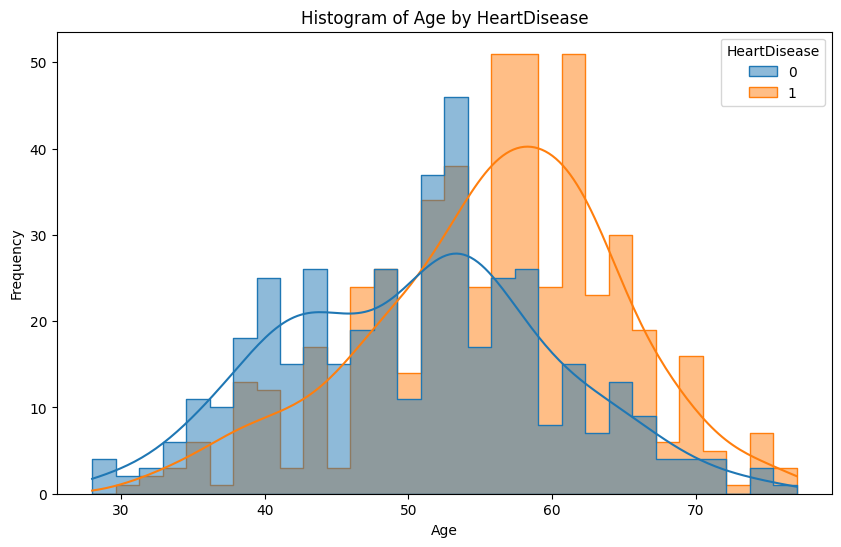

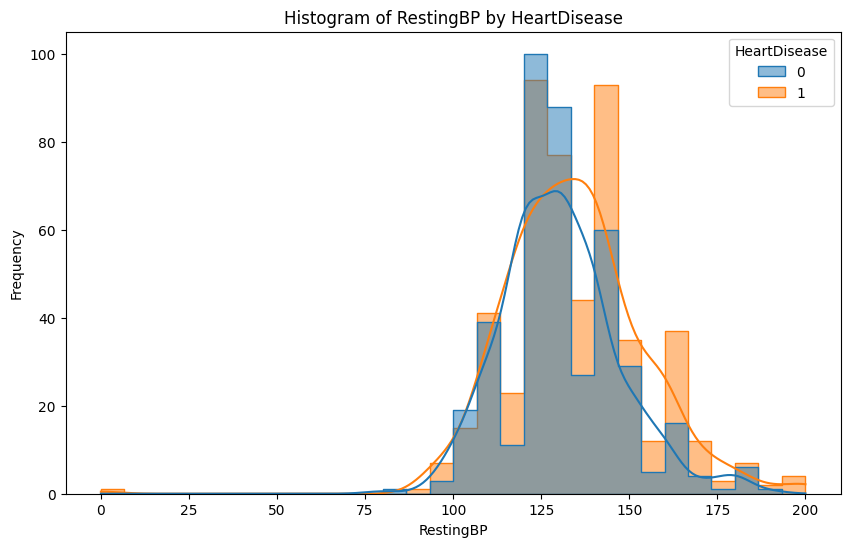

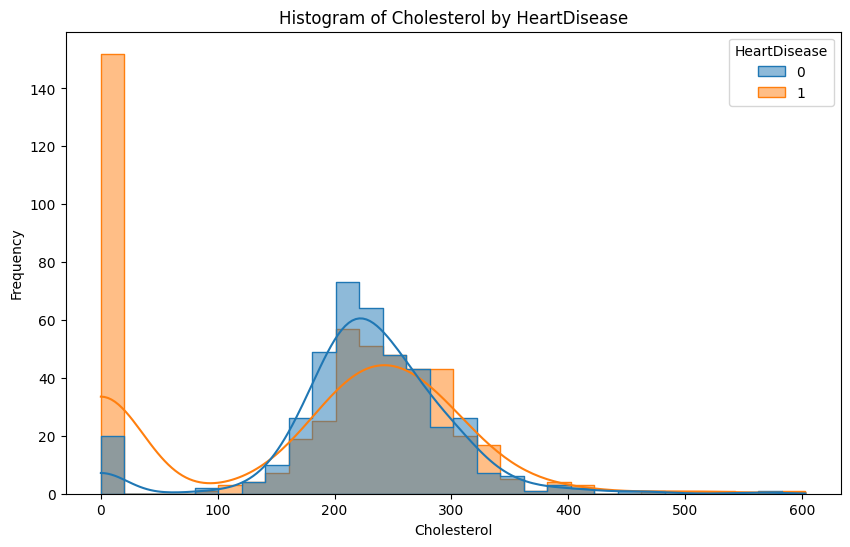

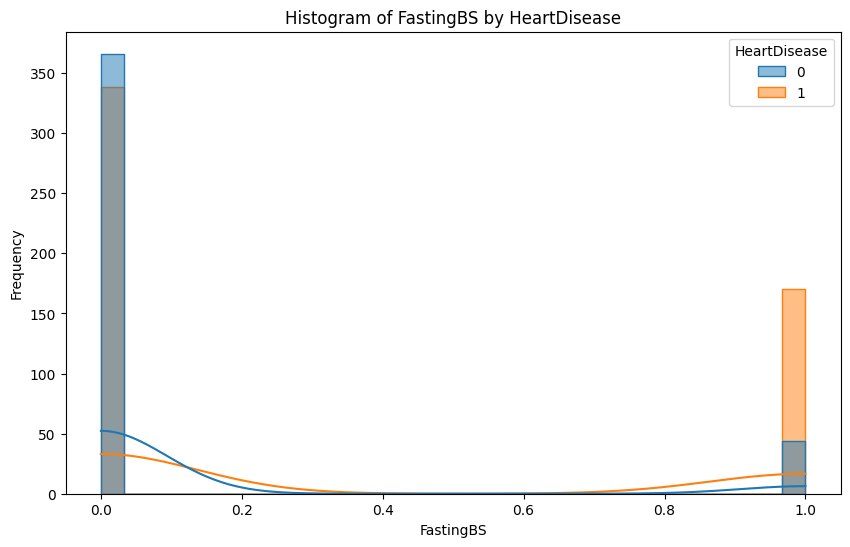

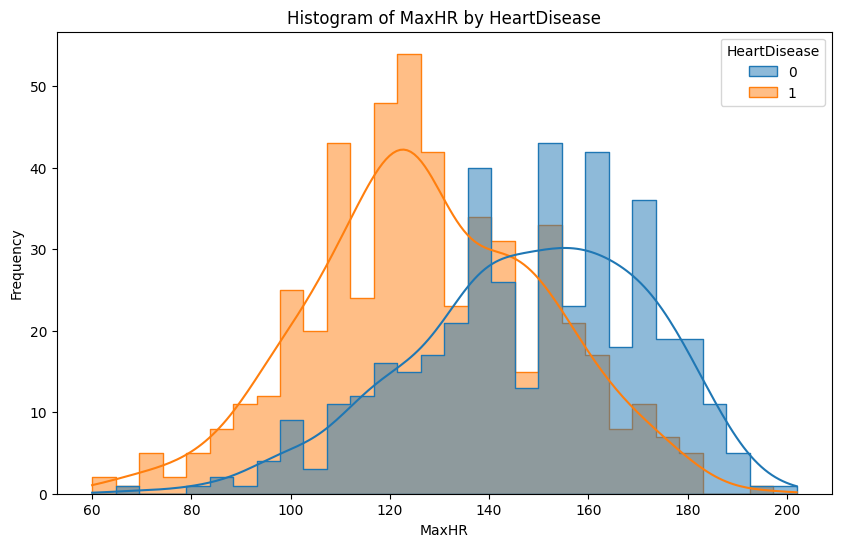

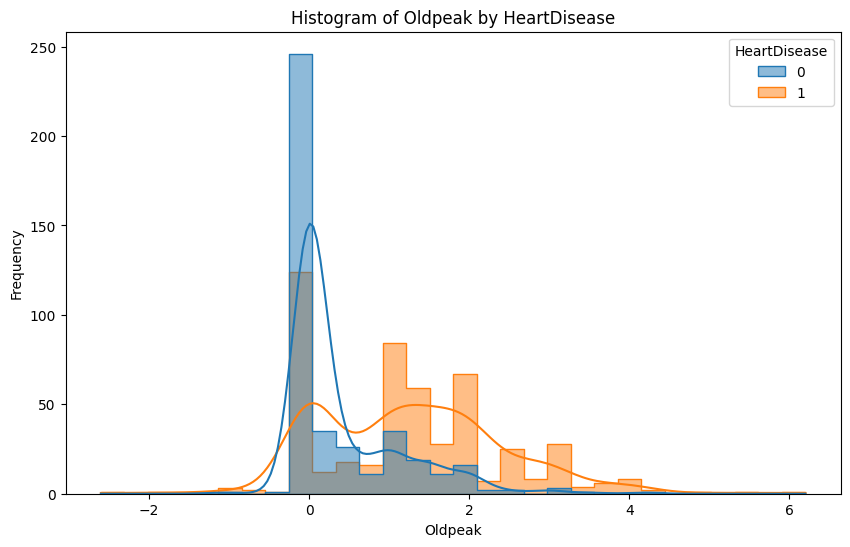

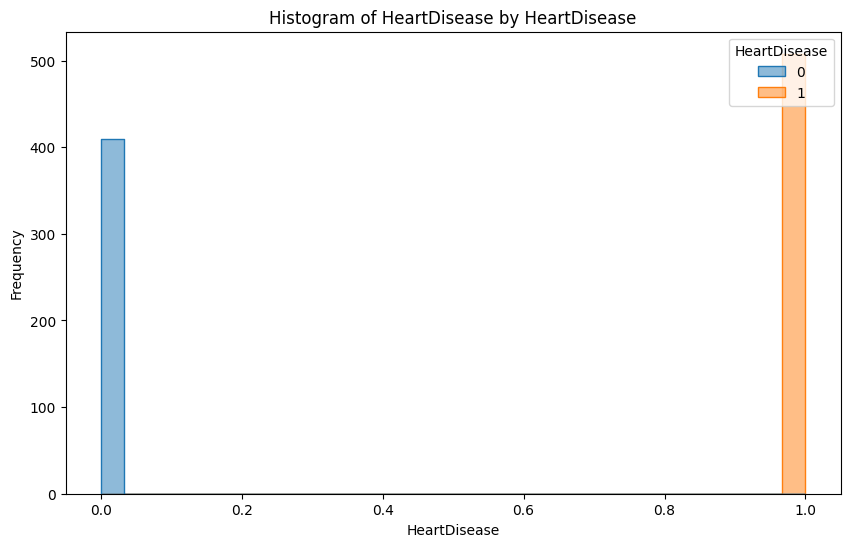

In [371]:
# Histogramme für numerische Variablen mit HeartDisease als Farbe
for column in numerische_spalten:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, hue='HeartDisease', bins=30, kde=True, palette='tab10', element="step", alpha=0.5)
    plt.title(f'Histogram of {column} by HeartDisease')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Die Visualisierungen Deuten Darauf hin, dass alle numerischen Feature bis auf `Oldpeak` Normalverteilt sind. 

Durch die Einteilung in Farbe nach der Zielvariable - lassen sich bereits Zusammenhänge erkennen. zB Ältere haben eher einen herzfehler als Jüngere, 

In den Featuren: Cholesterol und RestingBp, wurden unrealistische Null Werte entdeckt, welche in dem Kapitel Data Preparation ind dem Unterpunkt Feature Engineering behandelt wird.

#### Boxplots- Ausreißer Analyse

Hier wird nocheinmal auf die Ausreißer eingegangen.

Da der Nüchternblutzucker(FastingBS) binäre Werte hat macht eine Boxplotdarstellung keinen Sinn (siehe .ReadMe).

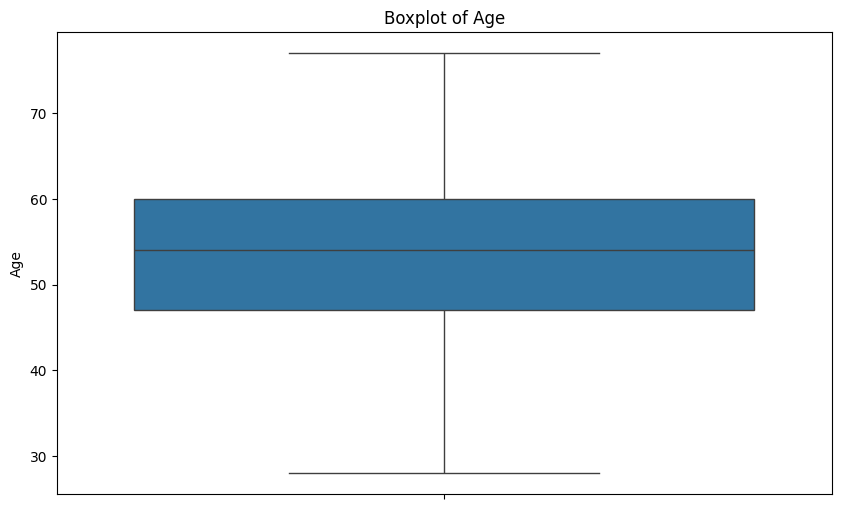

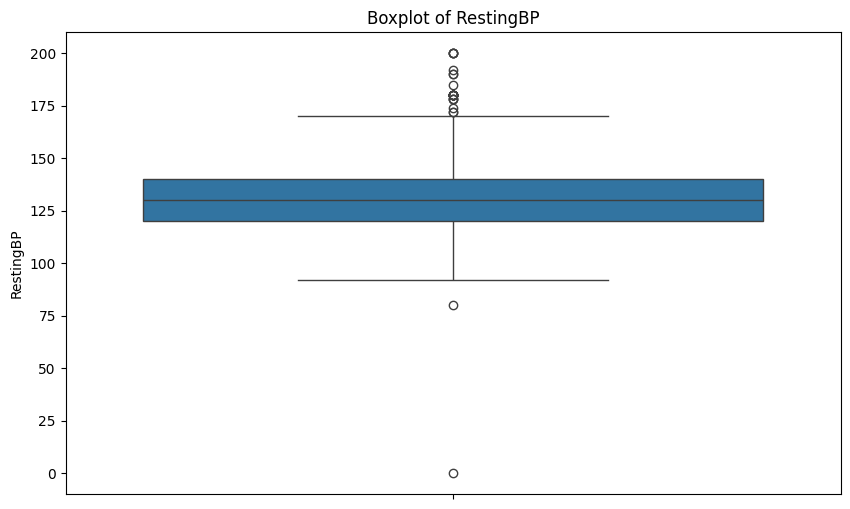

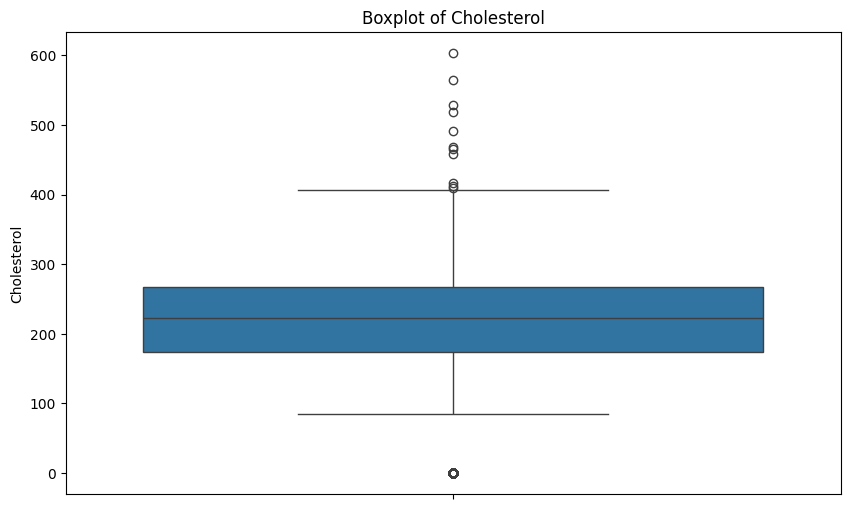

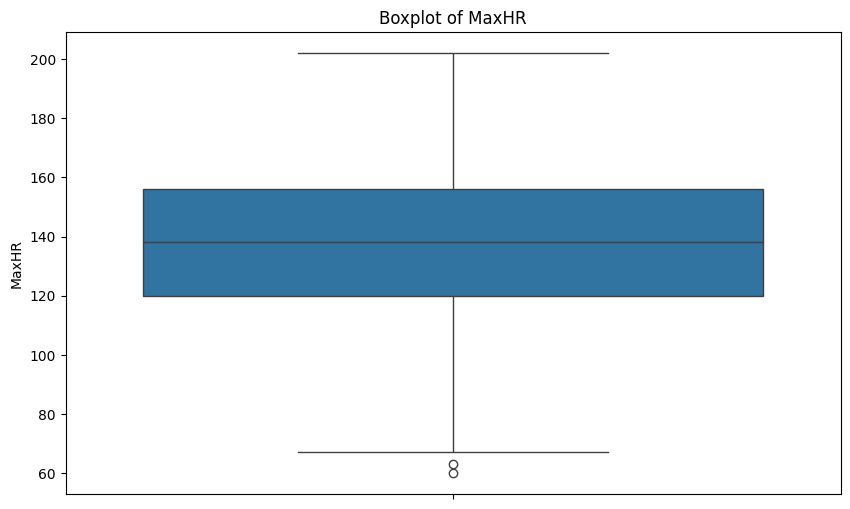

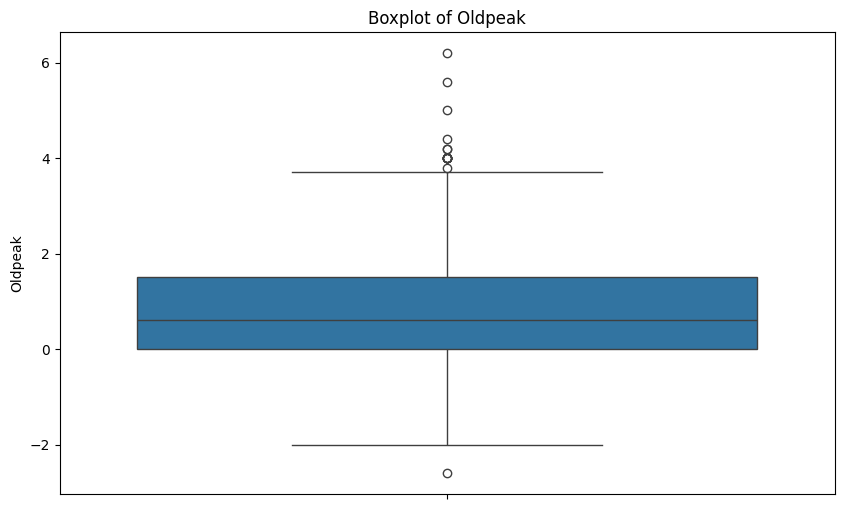

In [372]:
exclude_columns = ['FastingBS', 'HeartDisease']
boxplot_columns = [col for col in numerische_spalten if col not in exclude_columns]

for column in boxplot_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.show()

#### Korrelationsmatrix

Die Matrix zeigt auf, dass alle numerischen Feature leicht bist mittel-stark korrelieren und somit relevant sein können für die Auswahl für das Training.

Mit steigendem Alter sinkt die MaxHR und mit sinkender MaxHR steigt das Risiko für einen Herzfehler

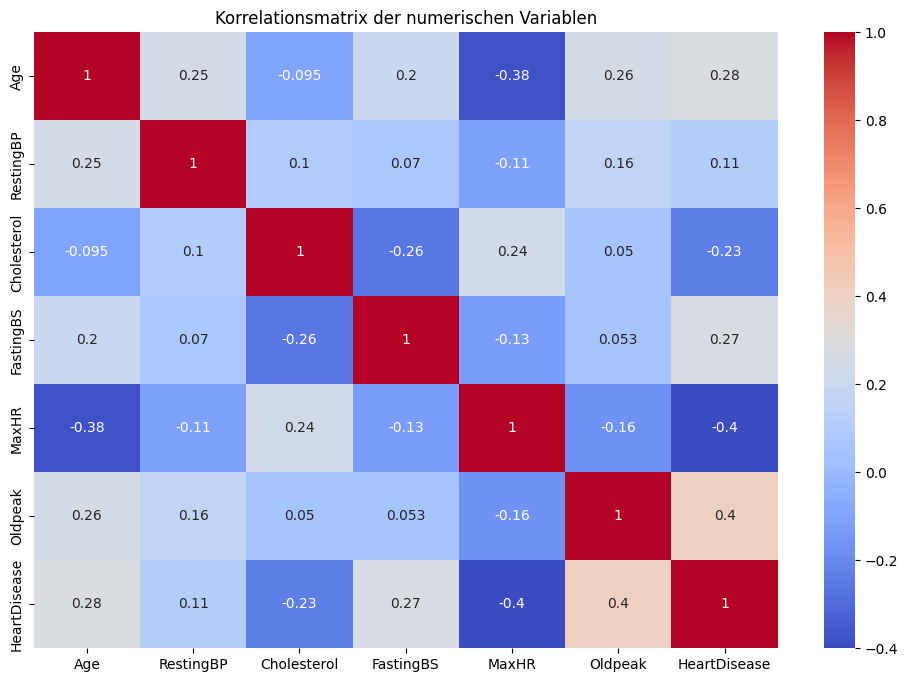

In [373]:
# Wir erstellen die Korrelationsmatrix nur für die numerischen Spalten
correlation_matrix = df[numerische_spalten].corr()

# Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix der numerischen Variablen')
plt.show()

### Visualisierung von kategorischen Feature

#### Häufigkeitsverteilungen

In der Verteilung des Geschlechts lässt sich ablesen, dass Männer überrepräsentiert sind. Insgesamt lassen sich keine besonderen Aufälligkeiten aufzeigen aus nicht med. Sicht.

/var/folders/vr/klm94mws7lsd0vj7h5gd2bqw0000gn/T/ipykernel_46844/848146752.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




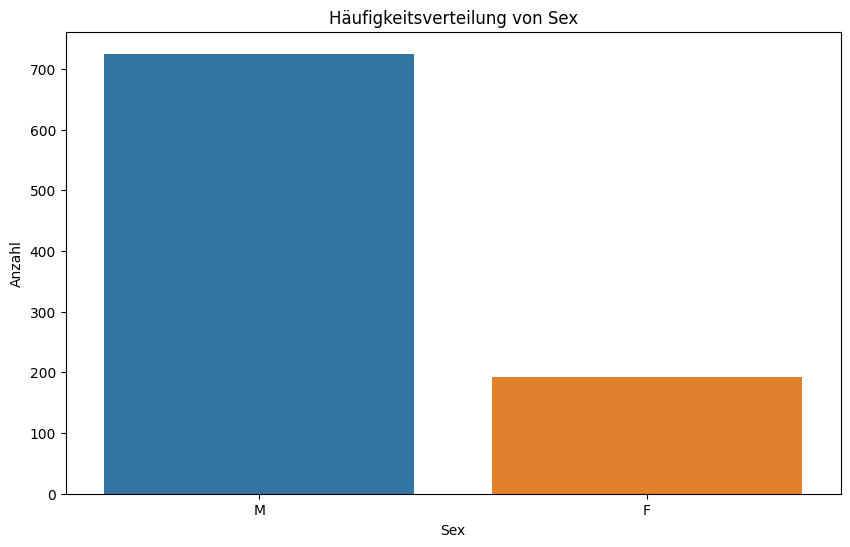

/var/folders/vr/klm94mws7lsd0vj7h5gd2bqw0000gn/T/ipykernel_46844/848146752.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




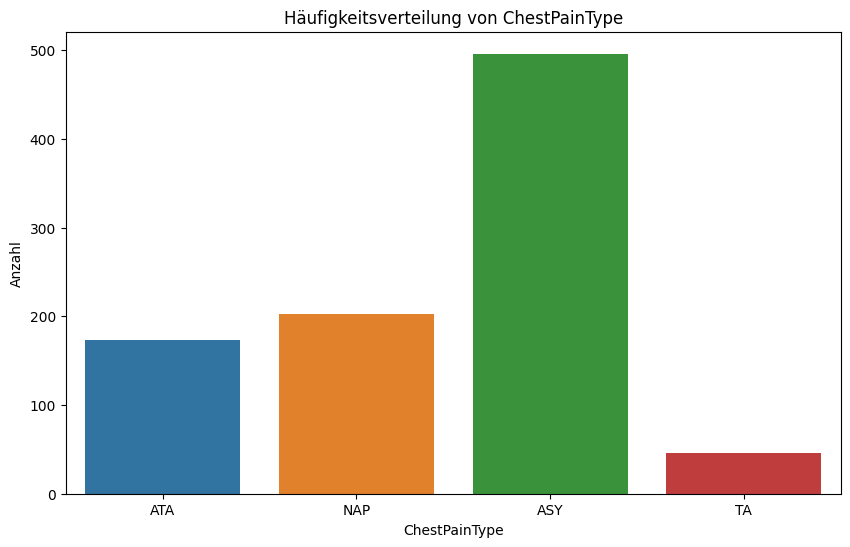

/var/folders/vr/klm94mws7lsd0vj7h5gd2bqw0000gn/T/ipykernel_46844/848146752.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




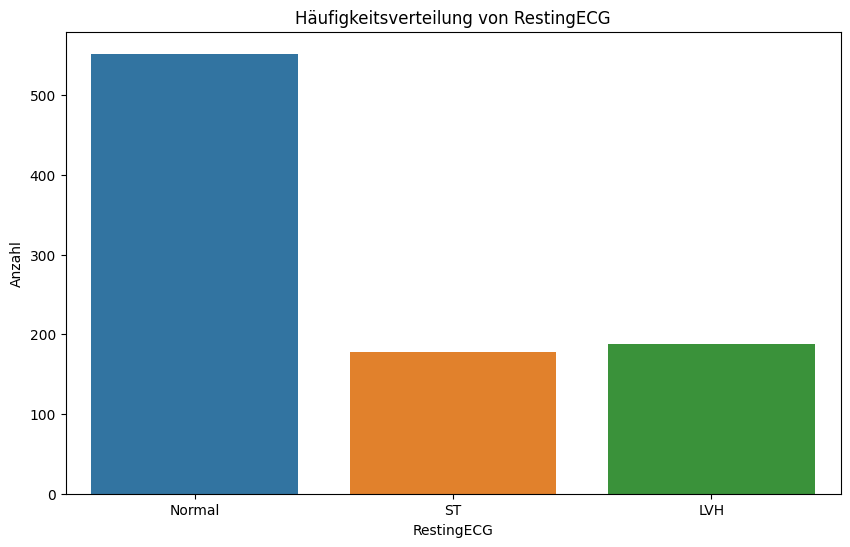

/var/folders/vr/klm94mws7lsd0vj7h5gd2bqw0000gn/T/ipykernel_46844/848146752.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




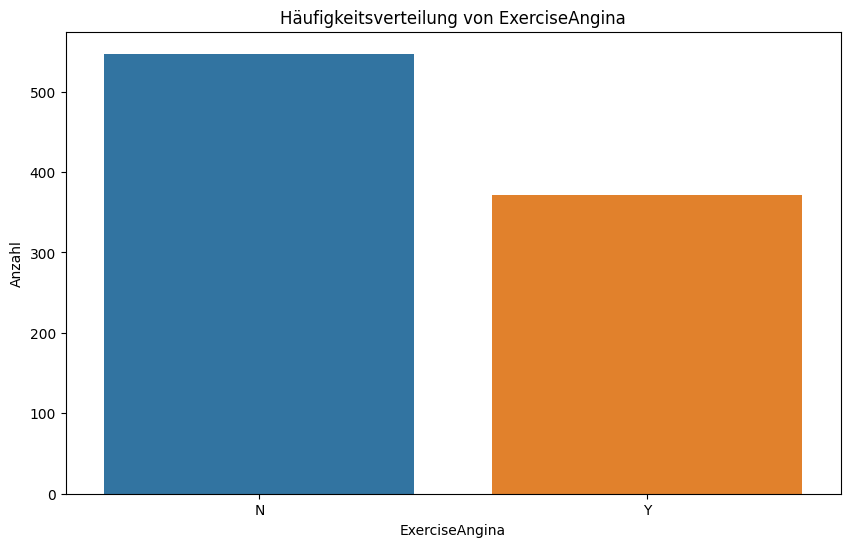

/var/folders/vr/klm94mws7lsd0vj7h5gd2bqw0000gn/T/ipykernel_46844/848146752.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




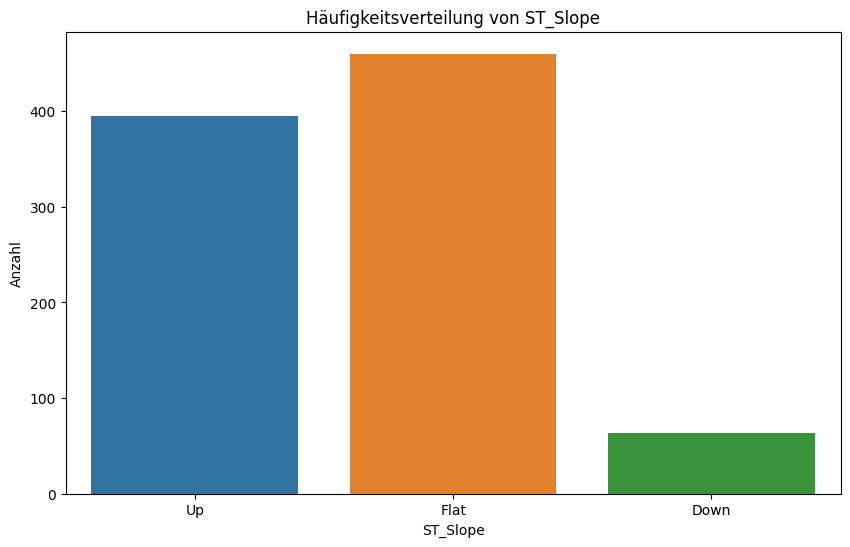

In [374]:
# Kategoriale Variablen identifizieren
kategoriale_spalten = df.select_dtypes(include=['object']).columns

# Häufigkeitsverteilungen anzeigen
for column in kategoriale_spalten:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, palette='tab10')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Anzahl')
    plt.show()


#### Häufigkeitsverteilung nach der Zielvariable

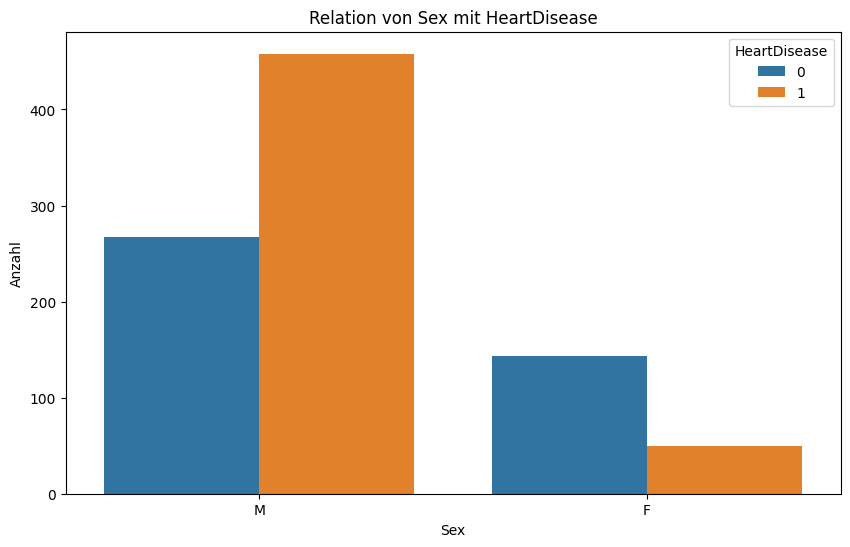

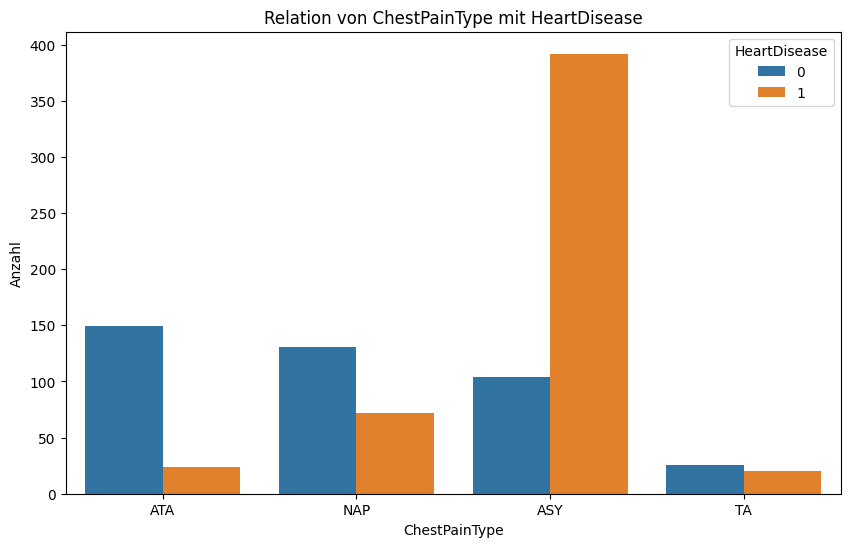

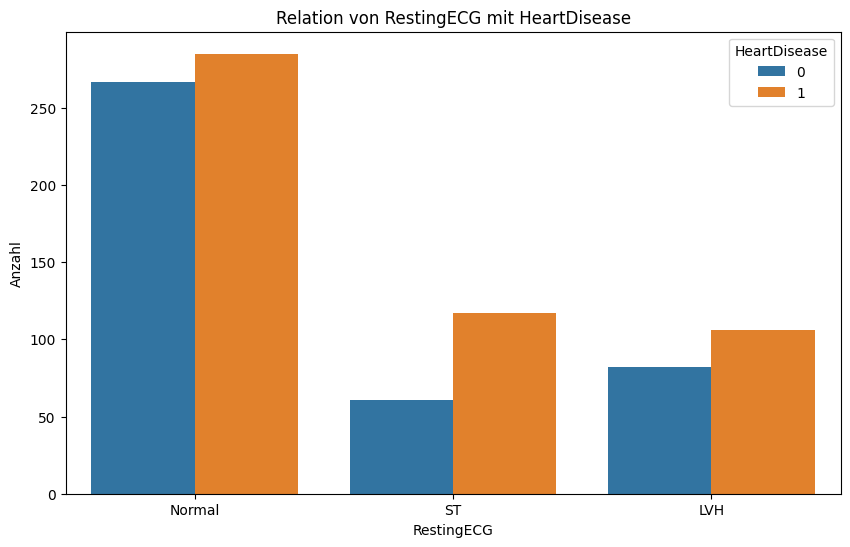

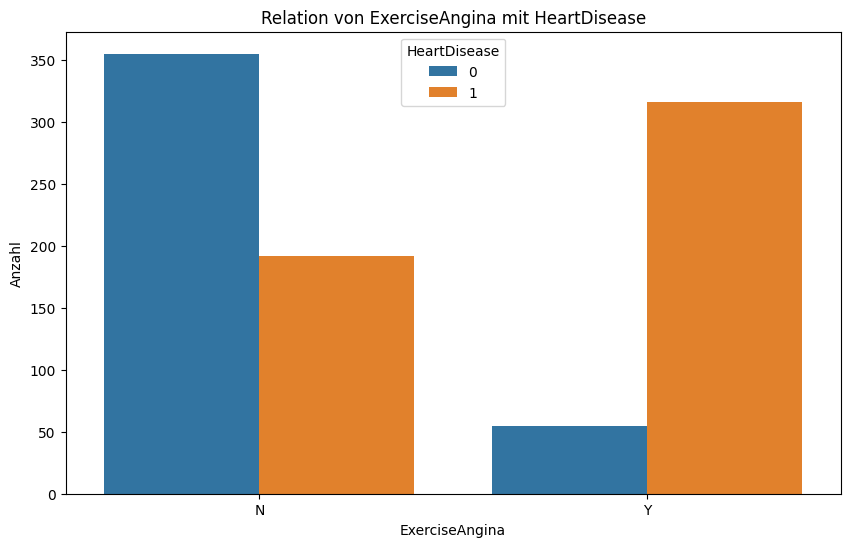

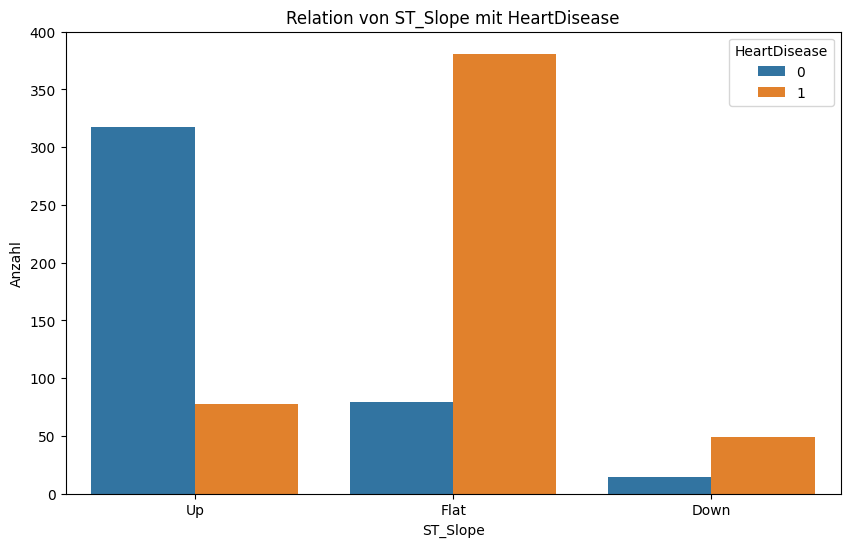

In [375]:
# Beziehung zwischen kategorialen Variablen und der Zielvariable
for column in kategoriale_spalten:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, hue='HeartDisease', palette='tab10')
    plt.title(f'Relation von {column} mit HeartDisease')
    plt.xlabel(column)
    plt.ylabel('Anzahl')
    plt.show()


### Tiefere Analyse der Feature

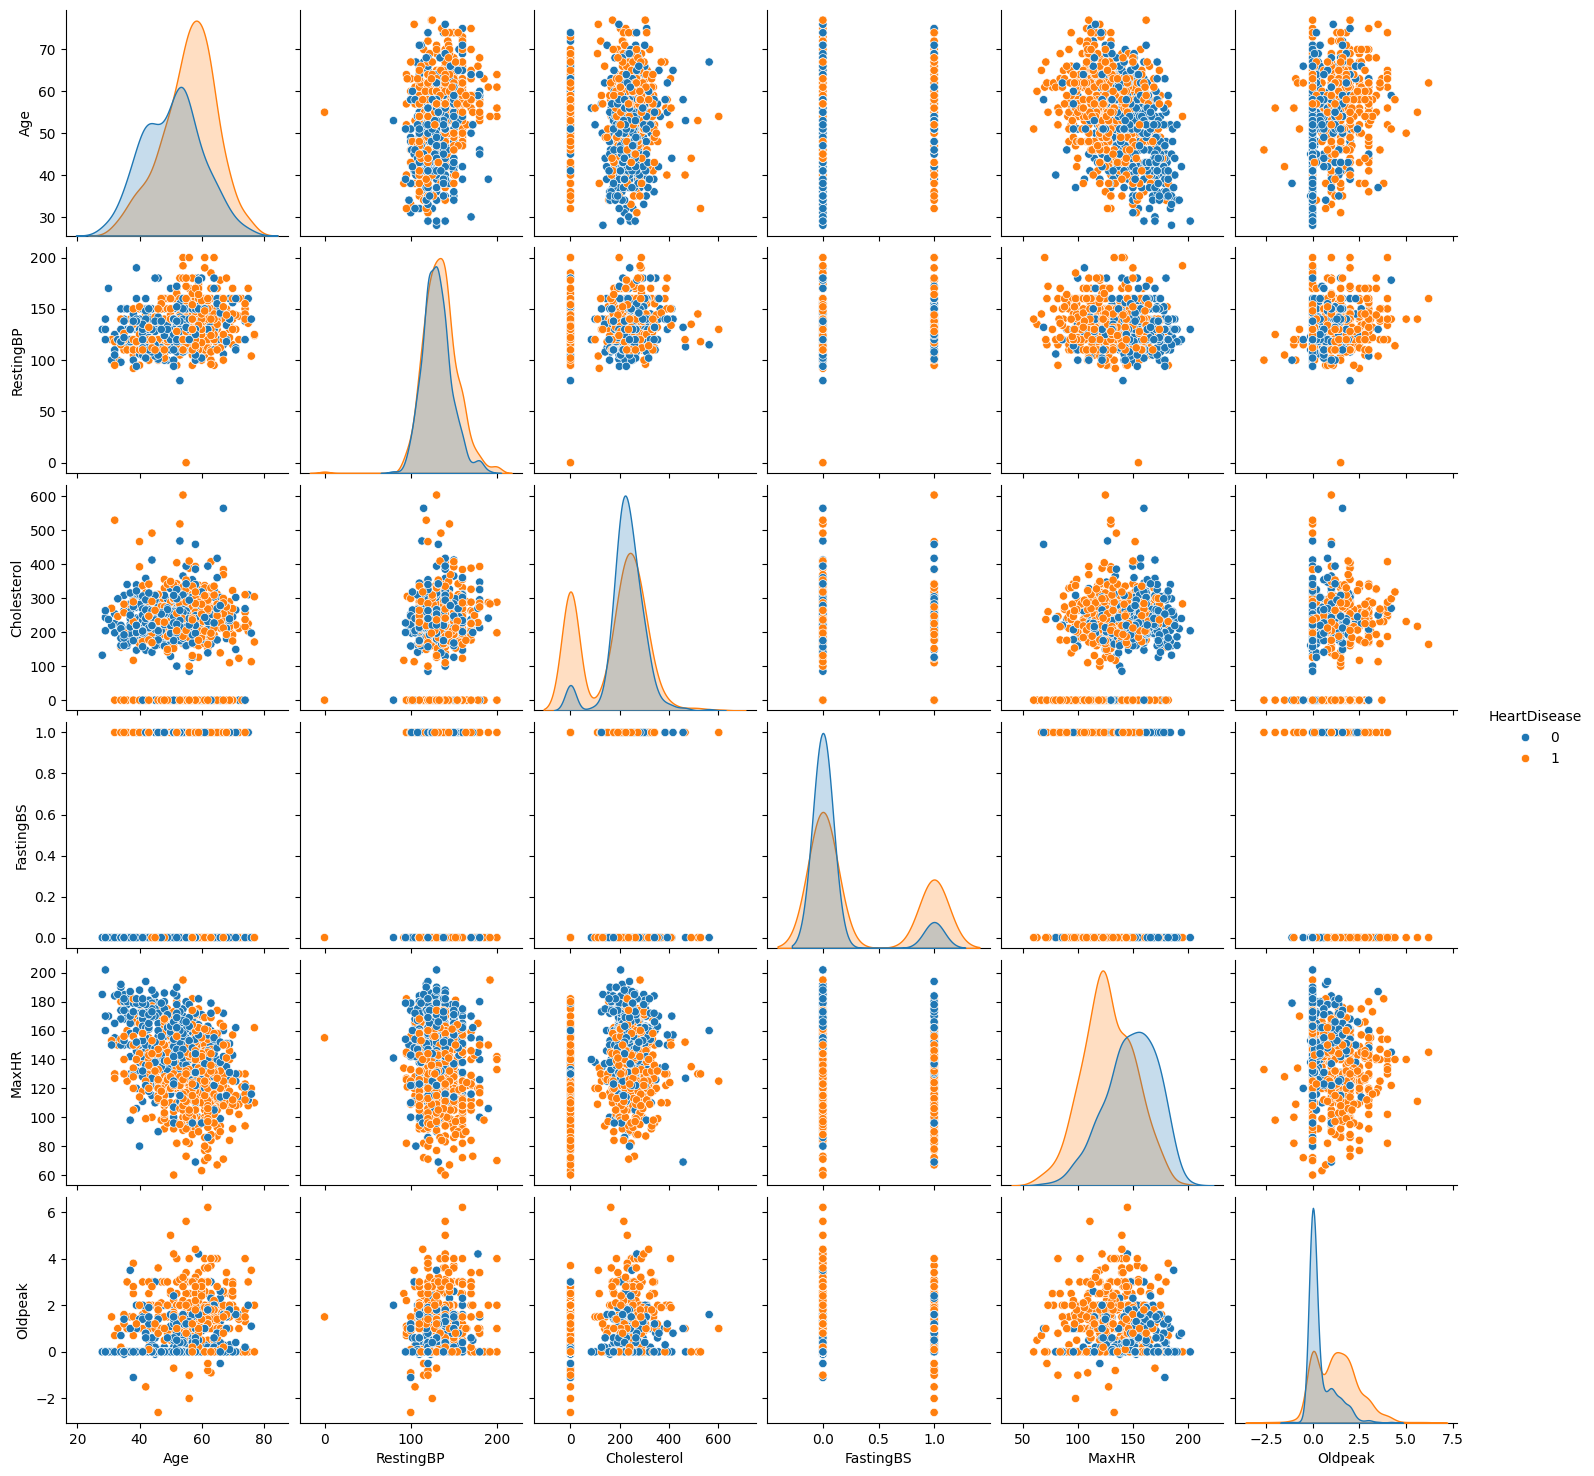

In [376]:
# Paarplot der numerischen Variablen
sns.pairplot(df, hue='HeartDisease', palette='tab10')
plt.show()

#### Korrelationsmatrix von kodierten Variablen

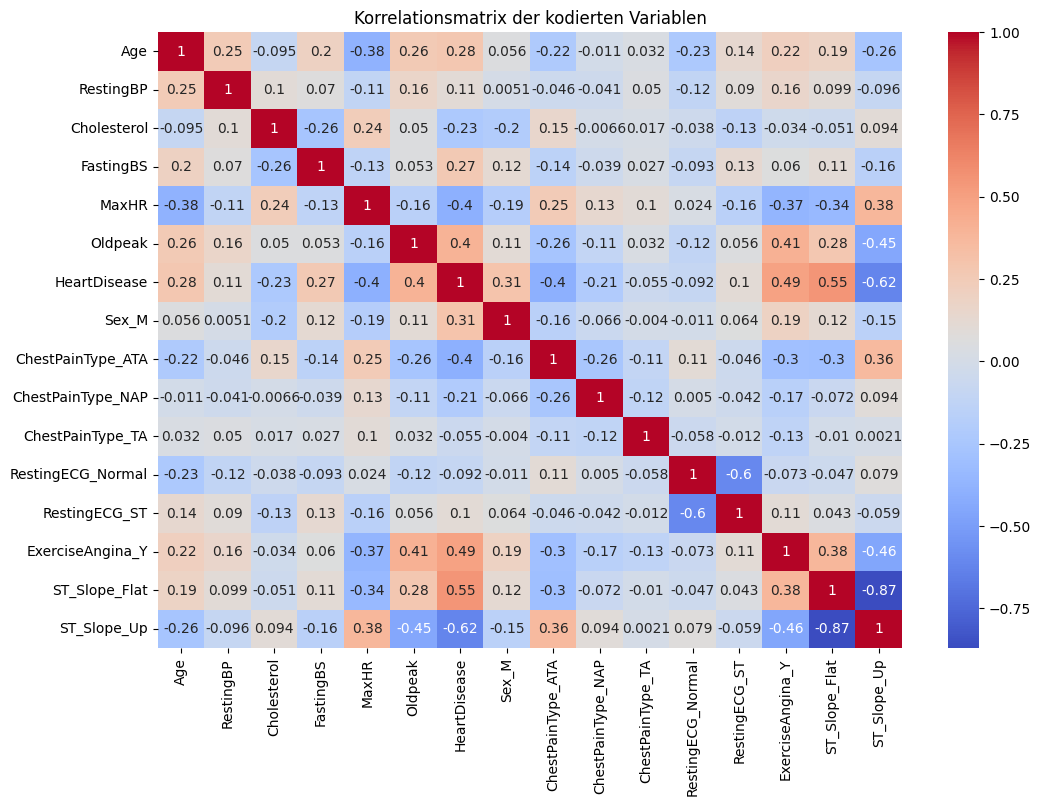

In [377]:
# Korrelationsmatrix für kategoriale Variablen
df_encoded = pd.get_dummies(df, drop_first=True)
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix der kodierten Variablen')
plt.show()


#### Zusammenhang und Beziehungen zwischen Featuren nach der Zielvariable

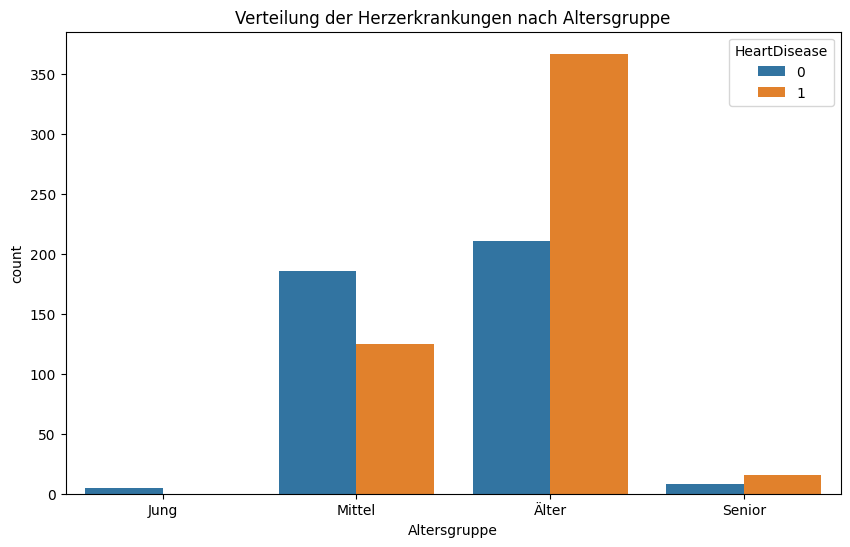

In [378]:
# Altersgruppenanalyse
ziel_variable = df['HeartDisease']

df['Altersgruppe'] = pd.cut(df['Age'], bins=[0, 30, 50, 70, 100], labels=['Jung', 'Mittel', 'Älter', 'Senior'])
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Altersgruppe', hue=ziel_variable)
plt.title('Verteilung der Herzerkrankungen nach Altersgruppe')
plt.show()


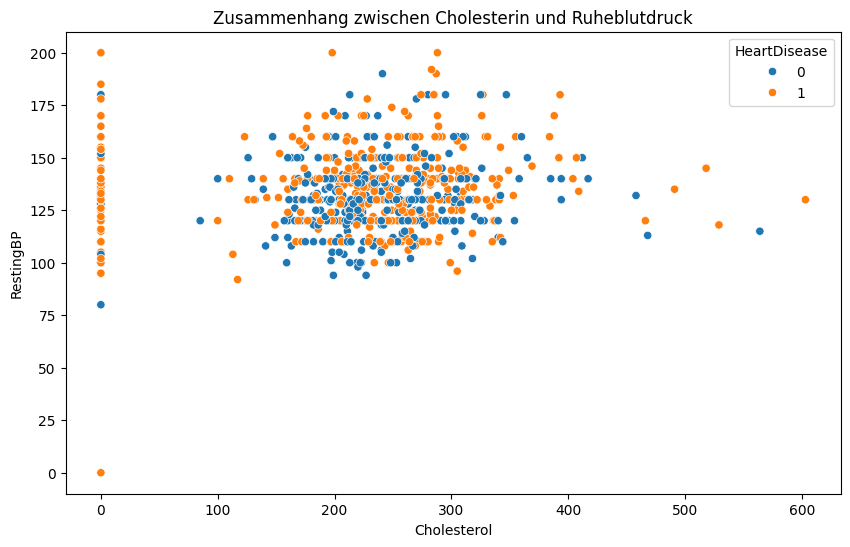

In [379]:
# Analyse des Zusammenhangs zwischen Cholesterin und Blutdruck
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Cholesterol', y='RestingBP', hue=ziel_variable)
plt.title('Zusammenhang zwischen Cholesterin und Ruheblutdruck')
plt.show()


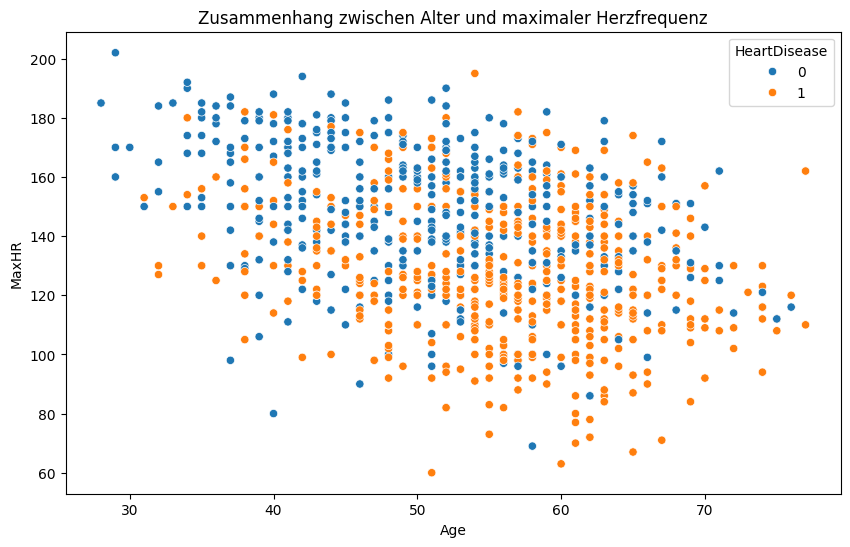

In [380]:
# Analyse des Zusammenhangs zwischen Alter und maximaler Herzfrequenz
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='MaxHR', hue=ziel_variable)
plt.title('Zusammenhang zwischen Alter und maximaler Herzfrequenz')
plt.show()

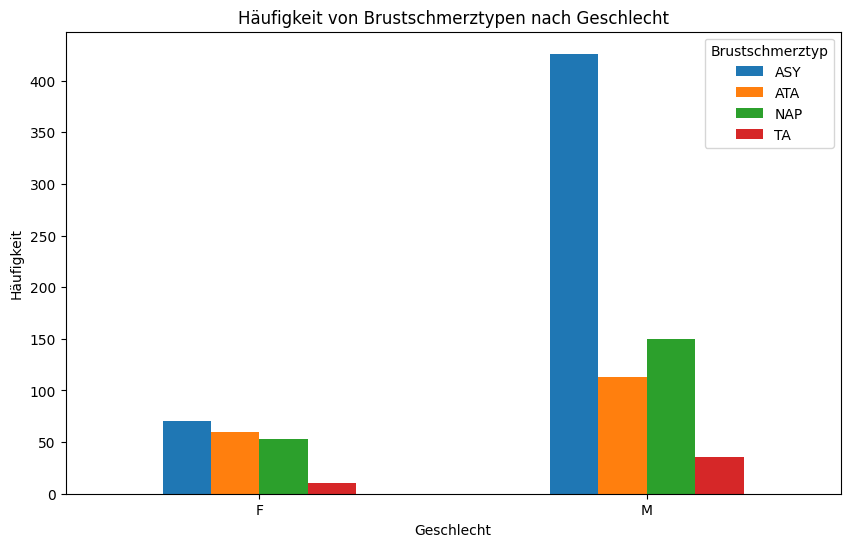

In [381]:
grouped = df.groupby(['Sex', 'ChestPainType']).size().unstack(fill_value=0)
grouped.plot(kind='bar', figsize=(10, 6))
 
# Titel und Labels hinzufügen
plt.title('Häufigkeit von Brustschmerztypen nach Geschlecht')
plt.xlabel('Geschlecht')
plt.ylabel('Häufigkeit')
plt.xticks(rotation=0)  # Dreht die X-Achsen-Beschriftungen horizontal
 
# Legende hinzufügen
plt.legend(title='Brustschmerztyp')
 
# Zeige das Diagramm an
plt.show()

## 4. Data Preparation 

### Datensatz überprüfen

#### Null Werte

In [382]:
# Fehlende Werte überprüfen
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
Altersgruppe      0
dtype: int64

#### Duplikate

In [383]:
# Duplikate überprüfen und entfernen
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

0
0


#### Datentypen überprüfen

In [384]:
# Nach Datentypen überprüfen
df.dtypes

Age                  int64
Sex                 object
ChestPainType       object
RestingBP            int64
Cholesterol          int64
FastingBS            int64
RestingECG          object
MaxHR                int64
ExerciseAngina      object
Oldpeak            float64
ST_Slope            object
HeartDisease         int64
Altersgruppe      category
dtype: object

### Feature Engineering

#### Altersgruppen bilden

In [385]:
# Feature Erstellung und Transformation
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-aged', 'Senior'])


#### Gruppen für Olpeak

In [386]:
df['Oldpeak'].unique()

array([ 0. ,  1. ,  1.5,  2. ,  3. ,  4. ,  0.5,  2.5,  5. ,  0.8,  0.7,
        1.4,  2.1,  0.4,  0.2,  1.7,  2.2,  0.1,  1.6,  1.3,  0.3,  1.8,
        2.6, -0.9,  2.8, -2.6, -1.5, -0.1,  0.9,  1.1,  2.4, -1. , -1.1,
       -0.7, -0.8,  3.7,  1.2, -0.5, -2. ,  1.9,  3.5,  0.6,  3.1,  2.3,
        3.4,  3.6,  4.2,  3.2,  5.6,  3.8,  2.9,  6.2,  4.4])

In [387]:
# Oldpeak in Bins einteilen
bins = [-3, 0, 2, 4, float('inf')]
labels = ['Normal', 'Mild', 'Moderate', 'Severe']
df['OldpeakBinned'] = pd.cut(df['Oldpeak'], bins=bins, labels=labels)

#### Fehlende Cholesterinwerte bearbeiten

In [388]:
# Mittelwert berechnen, ohne die Nullwerte zu berücksichtigen
cholesterol_mean = df['Cholesterol'].replace(0, np.nan).mean()

cholesterol_mean

244.6353887399464

In [389]:
# Nullwerte durch den Mittelwert ersetzen
df['Cholesterol'] = df['Cholesterol'].replace(0, cholesterol_mean)

In [390]:
df['Cholesterol'].loc[df['Cholesterol']==0].count()

0

#### Auswahl der Features

- Numerische Feature:
In unserem konkreten Fall wurde für das Merkmal "Oldpeak" eine Normalisierung durchgeführt. Der Grund dafür liegt in der rechtsschiefen Verteilung dieser Daten.
Für die Merkmale Alter, Blutdruck im Ruhezustand, Cholesterinwerte und maximale Herzfrequenz wurde hingegen eine Standardisierung angewandt. Diese Entscheidung basiert auf der Beobachtung, dass diese Variablen einer Normalverteilung folgen.

- Kategorielle Feature:
Hier haben wir uns dazu entschieden unsere Kategorien zu encoden und fehlende Werte mit dem häufisten Wert zu ersetzten.

In [391]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'AgeGroup', 'OldpeakBinned']
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

#### Einstellung des Preprocessing

In [392]:
# Numerische Features aufteilen
features_to_normalize = ['Oldpeak']
features_to_standardize = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
other_numeric_features = ['FastingBS']

# Pipeline für zu normalisierende Features
normalize_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('normalizer', MinMaxScaler())
])

# Pipeline für zu standardisierende Features
standardize_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline für andere numerische Features
other_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Preprocessing Pipeline für kategorische Daten (unverändert)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kombination der Preprocessing Schritte
preprocessor = ColumnTransformer(
    transformers=[
        ('normalize', normalize_transformer, features_to_normalize),
        ('standardize', standardize_transformer, features_to_standardize),
        ('other_num', other_numeric_transformer, other_numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#### Anwendung des preprocessing für Übersicht und Debugging

In [393]:
# Anwenden des Preprocessings
X = preprocessor.fit_transform(df)

# Erstellen eines neuen DataFrames mit den transformierten Daten
numeric_feature_names = features_to_normalize + features_to_standardize + other_numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_feature_names + categorical_feature_names

df_transformed = pd.DataFrame(X, columns=feature_names)

# Hinzufügen der Zielvariable
df_transformed['HeartDisease'] = df['HeartDisease']

In [394]:
df_transformed.head()

,Oldpeak,Age,RestingBP,Cholesterol,MaxHR,FastingBS,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,ST_Slope_Flat,ST_Slope_Up,AgeGroup_Middle-aged,AgeGroup_Senior,AgeGroup_Young,OldpeakBinned_Mild,OldpeakBinned_Moderate,OldpeakBinned_Normal,OldpeakBinned_Severe,HeartDisease
0,0.295455,-1.433140,0.410909,0.832529,1.382928,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.409091,-0.478484,1.491752,-1.212922,0.754157,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,0.295455,-1.751359,-0.129513,0.719935,-1.525138,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.465909,-0.584556,0.302825,-0.574892,-1.132156,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,0.295455,0.051881,0.951331,-0.931438,-0.581981,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


#### Preprocessed Features Analyse

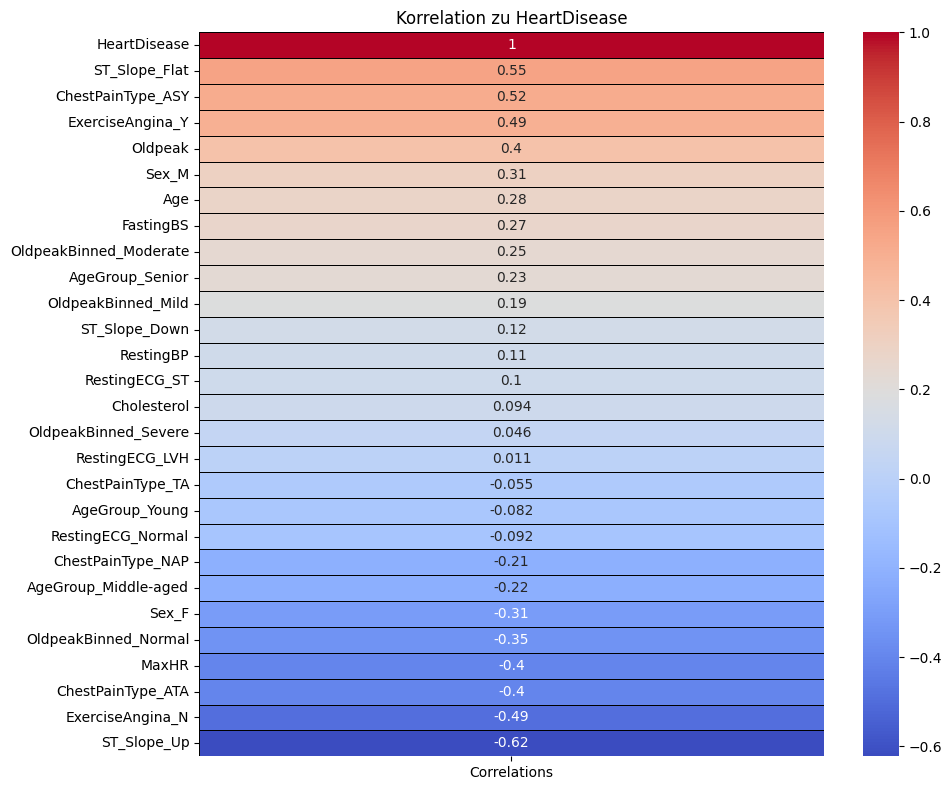

In [395]:
# Berechnung der Korrelationen
corr = df_transformed.corrwith(df_transformed['HeartDisease']).sort_values(ascending=False).to_frame()
corr.columns = ['Correlations']

# Visualisierung
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black')
plt.title('Korrelation zu HeartDisease')
plt.tight_layout()
plt.show()

### Trainings- und Testdatensätze

In [396]:
# Aufteilen der Daten in Trainings- und Testdatensätze
X = df_transformed.drop('HeartDisease', axis=1)
y = df_transformed['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Modelle


### Lazy Predict

In [397]:
#lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)
#models, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test )

In [398]:
#print(models)

### Decision Tree

In [399]:
decision_tree_clf = DecisionTreeClassifier(random_state=42)
decision_tree_clf.fit(X_train, y_train)

y_pred = decision_tree_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7880434782608695


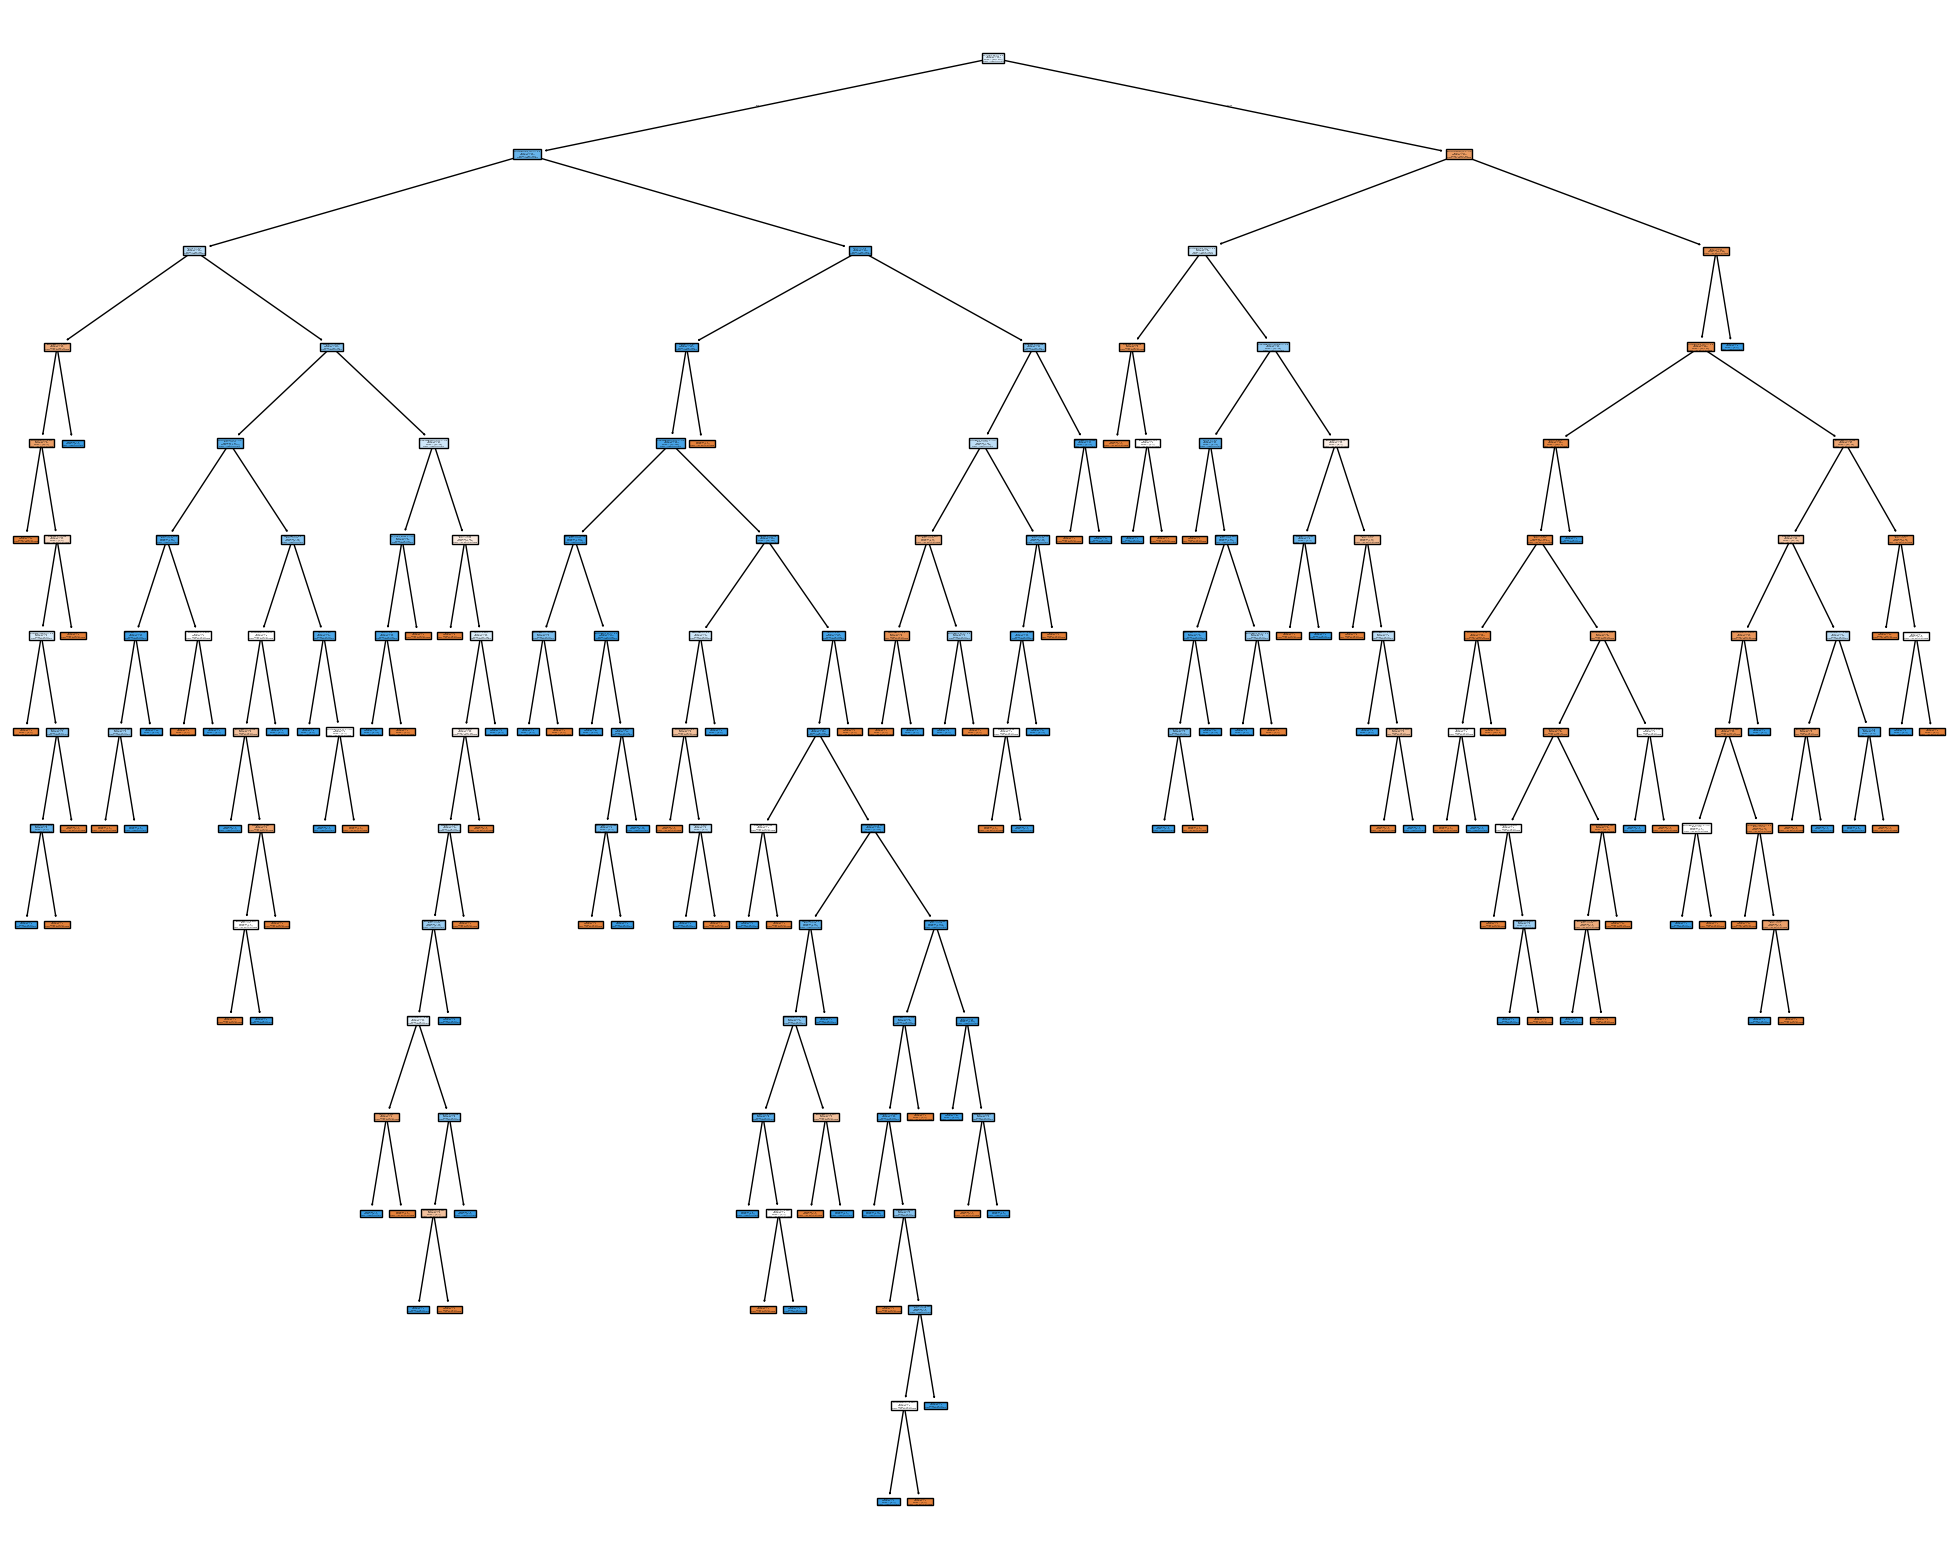

In [429]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_clf,
                   feature_names=X.columns,
                   class_names=['No Heart Disease', 'Heart Disease'],
                   filled=True)
fig.savefig('decisiontree.png')

### SelectKBest

Die 7 'besten' Feature werden von SelectKBest selektiert. Da bei uns jedoch die Performance wieder sank, haben wir uns gegen eine einbindung entschieden.

In [ ]:
# Feature Selection
pipeline = Pipeline([
    ('scaler', StandardScaler()),             # Preprocessing: Daten skalieren
    ('feature_selection', SelectKBest(f_classif, k=7)),  # Feature Selection: Die zwei besten Features auswählen
    ('classifier', RandomForestClassifier())  # Klassifikator: RandomForest
])

# Pipeline trainieren
pipeline.fit(X_train, y_train)

# Ausgewählte Features bekommen
selected_features_bool = pipeline.named_steps['feature_selection'].get_support()
selected_features_scores = pipeline.named_steps['feature_selection'].scores_

# Namen der ausgewählten Features extrahieren (wenn die Feature-Namen bekannt sind)
feature_names = X.columns
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_features_bool[i]]

print("Ausgewählte Features:", selected_feature_names)
print("Scores der Features:", np.round(selected_features_scores, 2))

Ausgewählte Features: ['Oldpeak', 'MaxHR', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']
Scores der Features: [1.5928e+02 7.2080e+01 1.4340e+01 3.8700e+00 1.5201e+02 5.2880e+01
 8.2640e+01 8.2640e+01 2.3668e+02 1.3752e+02 2.8840e+01 1.6000e+00
 2.3000e-01 6.3500e+00 6.9600e+00 2.7862e+02 2.7862e+02 1.0570e+01
 3.4098e+02 4.8401e+02 4.4730e+01 4.8280e+01 3.6400e+00 2.4570e+01
 5.6330e+01 1.0810e+02 2.0100e+00]


### Mutual Information

Mutual Information (MI) ist ein Werkzeug, das misst, wie stark zwei Dinge miteinander zu tun haben. Wenn der MI-Wert hoch ist, hängen die Dinge eng zusammen. MI zeigt nur, wie stark der Zusammenhang ist, aber nicht ob er gut oder schlecht ist. Das ist anders als bei anderen Methoden. MI kann auch schwierige Verbindungen finden, die man sonst leicht übersieht. In der Arbeit mit Daten hilft MI, wichtige Teile zu entdecken. Teile, die viel mit dem Ziel zu tun haben, sind oft sehr nützlich für Vorhersagen.

In [430]:
discrete_features = X.dtypes == float

In [431]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-p

Cholesterol               0.223062
MaxHR                     0.161544
ExerciseAngina_Y          0.131680
Age                       0.073583
Sex_M                     0.047477
OldpeakBinned_Moderate    0.035727
ChestPainType_NAP         0.022697
RestingECG_ST             0.005351
ChestPainType_TA          0.001490
Name: MI Scores, dtype: float64

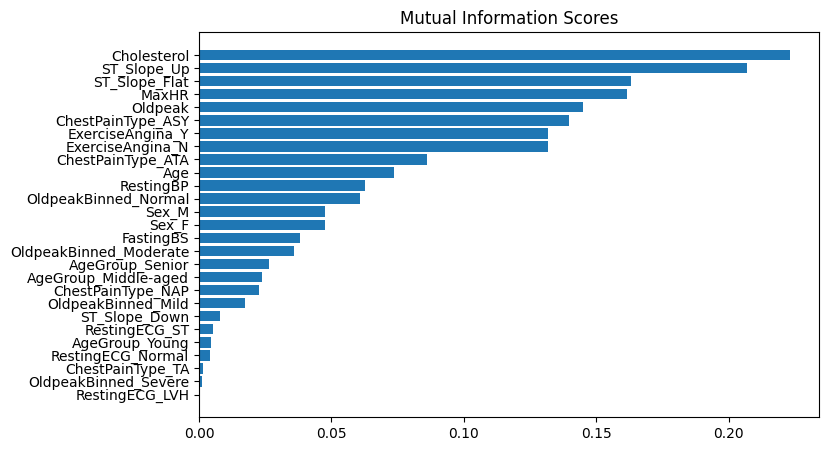

In [432]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Modell Definitionen

In [433]:
# Modelle definieren
models = {
    'Logistic Regression': Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('model', RandomForestClassifier())
    ]),
    'Support Vector Machine': Pipeline([
        # ('feature_selection', SelectKBest(score_func=f_classif)),
        ('model', SVC(probability=True))
    ]),
    'Gradient Boosting': Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('model', GradientBoostingClassifier())
    ]),
    'XGBoost': Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('model', xgb.XGBClassifier())
    ]),
    'LGBMClassifier': Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('model', LGBMClassifier(verbose=-1))
    ])
}

### Hyperparameter 

In [434]:
param_dists = {
    'Logistic Regression': {
        'feature_selection__k': range(1, X_train.shape[1] + 1),
        'model__C': np.logspace(-4, 4, 20),
        'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag']
    },
    'Random Forest': {
        'feature_selection__k': range(1, X_train.shape[1] + 1),
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'Support Vector Machine': {
        # 'feature_selection__k': [10],
        'model__C': np.logspace(-3, 3, 7),
        'model__gamma': np.logspace(-3, 3, 7),
        'model__kernel': ['rbf', 'poly', 'sigmoid']
    },
    'Gradient Boosting': {
        'feature_selection__k': range(1, X_train.shape[1] + 1),
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5]
    },
    'XGBoost': {
        'feature_selection__k': range(1, X_train.shape[1] + 1),
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_child_weight': [1, 3, 5]
    },
    'LGBMClassifier': {
        'feature_selection__k': range(1, X_train.shape[1] + 1),
        'model__num_leaves': [31, 62, 127],  # Typische Werte für num_leaves
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [-1, 10, 20]  # -1 steht für keine Begrenzung
    }
}

### Random und Grid Search

Die Funktion beinhaltet eine kombination aus random und Grid Search. Die Idee war, zuerst mittels einer Random Search den Werteraum grob zu überprüfen und anschließend mittels einer Grid Search noch granularer abzusuchen. Da die Performance jedoch nicht besser wurde haben wir diesen Ansatz wieder Verworfen. Es wurde sich für die Random Search entschieden um die Wahrscheihnlichkeit zu erhöhen performante Werte zu finden ohne hohe Rechenleistung in anspruch zu nehmen.

def random_grid_search_cv(models, param_dists, X_train, y_train, n_splits=5, n_iter=30):
    best_estimators = {}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"Processing {name}...")
        
        # Berechne die Gesamtzahl der Parameterkombinationen
        n_combinations = np.prod([len(v) for v in param_dists[name].values()])
        
        # Passe n_iter an, wenn nötig
        actual_n_iter = min(n_iter, n_combinations)
        
        # Randomized Search mit Cross-Validation
        random_search = RandomizedSearchCV(model, param_dists[name], n_iter=actual_n_iter, cv=kf, n_jobs=-1, random_state=42, scoring='accuracy')
        random_search.fit(X_train, y_train)
        
        # Grid Search mit den besten Parametern aus Randomized Search
        best_params = random_search.best_params_
        refined_params = {k: [v] if not isinstance(v, list) else v for k, v in best_params.items()}
        grid_search = GridSearchCV(model, refined_params, cv=kf, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        best_estimators[name] = grid_search.best_estimator_
        
        # Cross-Validation Score
        cv_scores = cross_val_score(best_estimators[name], X_train, y_train, cv=kf, scoring='accuracy')
        
        print(f"Best Model: {name}")
        print("Best Parameters:", grid_search.best_params_)
        print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print("\n")
    
    return best_estimators

#### Def. Random Search

In [435]:
def random_search_cv(models, param_dists, X, y, n_splits=5, n_iter=100, scoring='accuracy'):
    best_estimators = {}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"Processing {name}...")
        
        # Berechne die Gesamtzahl der Parameterkombinationen
        n_combinations = np.prod([len(v) for v in param_dists[name].values()])
        
        # Passe n_iter an, wenn nötig
        actual_n_iter = min(n_iter, n_combinations)
        
        # Randomized Search mit Cross-Validation
        random_search = RandomizedSearchCV(
            model, 
            param_dists[name], 
            n_iter=actual_n_iter, 
            cv=kf, 
            n_jobs=-1, 
            random_state=42, 
            scoring=scoring,
            return_train_score=True  # Hilft bei der Diagnose von Overfitting
        )
        random_search.fit(X, y)
        
        best_estimators[name] = random_search.best_estimator_
        
        # Cross-Validation Score
        cv_scores = cross_val_score(best_estimators[name], X, y, cv=kf, scoring=scoring)
        
        print(f"Best Model: {name}")
        print("Best Parameters:", random_search.best_params_)
        print(f"Best Cross-Validation {scoring}: {random_search.best_score_:.4f}")
        print(f"Cross-Validation {scoring}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"Train {scoring}: {random_search.cv_results_['mean_train_score'][random_search.best_index_]:.4f}")
        print("\n")
    
    return best_estimators

#### Def. Grid Search

In [436]:
def grid_search_cv(models, param_grids, X, y, n_splits=5, scoring='accuracy'):
    best_estimators = {}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"Processing {name}...")
        
        # Grid Search mit Cross-Validation
        grid_search = GridSearchCV(
            model, 
            param_grids[name], 
            cv=kf, 
            n_jobs=-1, 
            scoring=scoring,
            return_train_score=True  # Hilft bei der Diagnose von Overfitting
        )
        grid_search.fit(X, y)
        
        best_estimators[name] = grid_search.best_estimator_
        
        # Cross-Validation Score
        cv_scores = cross_val_score(best_estimators[name], X, y, cv=kf, scoring=scoring)
        
        print(f"Best Model: {name}")
        print("Best Parameters:", grid_search.best_params_)
        print(f"Best Cross-Validation {scoring}: {grid_search.best_score_:.4f}")
        print(f"Cross-Validation {scoring}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"Train {scoring}: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]:.4f}")
        print("\n")
    
    return best_estimators

### Training und Hyperparameter Tuning

Modellvergleich:

- Leistung der Modelle größtenteils homogen
- Geringfügige Verbesserungen gegenüber Lazy Predict
- Random Search erzielte die besten Ergebnisse

In [437]:
best_models = random_search_cv(models, param_dists, X_train, y_train)


Processing Logistic Regression...


/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Best Model: Logistic Regression
Best Parameters: {'model__solver': 'sag', 'model__C': 1438.44988828766, 'feature_selection__k': 17}
Best Cross-Validation accuracy: 0.8651
Cross-Validation accuracy: 0.8651 (+/- 0.0522)
Train accuracy: 0.8706


Processing Random Forest...
Best Model: Random Forest
Best Parameters: {'model__n_estimators': 50, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': None, 'feature_selection__k': 20}
Best Cross-Validation accuracy: 0.8651
Cross-Validation accuracy: 0.8569 (+/- 0.0609)
Train accuracy: 0.9063


Processing Support Vector Machine...
Best Model: Support Vector Machine
Best Parameters: {'model__kernel': 'rbf', 'model__gamma': 0.001, 'model__C': 100.0}
Best Cross-Validation accuracy: 0.8610
Cross-Validation accuracy: 0.8610 (+/- 0.0471)
Train accuracy: 0.8726


Processing Gradient Boosting...
Best Model: Gradient Boosting
Best Parameters: {'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'feat

KeyboardInterrupt: 

## 6. Evaluation

### Funktionen

#### Def. Konfusion Matrix

In [ ]:
def plot_confusion_matrix_plotly(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Erstellen der Heatmap mit Plotly
    fig = px.imshow(cm,
                    labels=dict(x="Predicted label", y="True label"),
                    x=['Negative', 'Positive'],
                    y=['Negative', 'Positive'],
                    title=f'Confusion Matrix - {model_name}',
                    color_continuous_scale='Blues',
                    text_auto=True)
    
    fig.update_layout(width=600, height=500)
    return fig

#### Def. ROC Plots

In [ ]:
def plot_roc_curves(models, X_test, y_test):
    fig = go.Figure()
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)
        
        fig.add_trace(go.Scatter(x=fpr, y=tpr,
                                 mode='lines',
                                 name=f'{name} (AUC = {auc_score:.3f})'))
    
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                             mode='lines',
                             name='Random Classifier',
                             line=dict(dash='dash', color='grey')))
    
    fig.update_layout(title='ROC Curves',
                      xaxis_title='False Positive Rate',
                      yaxis_title='True Positive Rate',
                      legend_title='Models',
                      width=800, height=600)
    
    return fig



#### Def. Accuracy und AUC Vergleich

In [ ]:
def plot_model_comparison_plotly(accuracies, auc_scores):
    fig = go.Figure()
    
    # Accuracy bars
    fig.add_trace(go.Bar(
        x=list(accuracies.keys()),
        y=list(accuracies.values()),
        name='Accuracy',
        text=[f'{acc:.3f}' for acc in accuracies.values()],
        textposition='auto',
    ))
    
    # AUC bars
    fig.add_trace(go.Bar(
        x=list(auc_scores.keys()),
        y=list(auc_scores.values()),
        name='AUC',
        text=[f'{auc:.3f}' for auc in auc_scores.values()],
        textposition='auto',
    ))
    
    fig.update_layout(
        title='Model Comparison - Accuracy and AUC',
        xaxis_title='Models',
        yaxis_title='Score',
        barmode='group',
        yaxis_range=[0, 1],  # Setzt die y-Achse von 0 bis 1 für Scores
        width=900,
        height=500
    )
    
    return fig

#### Def. Feature Importance

In [ ]:
def plot_feature_importance(model, X, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Feature importance not available for {model_name}")
        return None
    
    feature_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    
    fig = px.bar(feature_imp, x='importance', y='feature', orientation='h',
                 title=f'Feature Importance - {model_name}')
    return fig





In [ ]:
def plot_shap_summary(model, X, model_name):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, plot_type="bar")
    plt.title(f'SHAP Summary - {model_name}')
    plt.tight_layout()
    plt.show()



In [ ]:
def plot_correlation_matrix(X):
    corr = X.corr()
    
    fig = px.imshow(corr, 
                    labels=dict(color="Correlation"),
                    x=corr.columns,
                    y=corr.columns,
                    title="Feature Correlation Matrix",
                    color_continuous_scale='RdBu_r',
                    zmin=-1, zmax=1)
    
    fig.update_layout(width=800, height=800)
    return fig



#### Def. Partial Dependence Plots

In [ ]:
def plot_pdp(model, X, feature_name, model_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    display = PartialDependenceDisplay.from_estimator(model, X, [feature_name], ax=ax)
    ax.set_title(f'Partial Dependence Plot - {feature_name} ({model_name})')
    plt.tight_layout()
    plt.show()



#### Def. Shap Werte

In [ ]:
def plot_shap_summary(model, X, model_name):
    # SHAP Explainer erstellen
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, xgb.XGBClassifier)):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X, 100))
    
    # SHAP-Werte berechnen
    shap_values = explainer.shap_values(X)
    
    # Bei binärer Klassifikation interessiert uns die positive Klasse
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # SHAP-Summary-Plot erstellen und anzeigen
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title(f'SHAP-Zusammenfassung - {model_name}')
    plt.tight_layout()
    plt.show()

### Evaluierung
Evaluierung
Die Evaluierung der Modelle umfasst mehrere Schritte und Techniken, die ein umfassendes Bild der Modellleistung und -interpretation liefern.

#### KonfusionMatrix
Konfusionsmatrix
Die Konfusionsmatrix ist ein wesentliches Werkzeug zur Visualisierung der Modellleistung bei Klassifikationsaufgaben. Sie stellt dar, wie viele Instanzen korrekt und falsch klassifiziert wurden:

True Positives (TP): Korrekt als positiv klassifizierte Instanzen
True Negatives (TN): Korrekt als negativ klassifizierte Instanzen
False Positives (FP): Fälschlicherweise als positiv klassifizierte Instanzen (Typ I Fehler)
False Negatives (FN): Fälschlicherweise als negativ klassifizierte Instanzen (Typ II Fehler)

Im Kontext der medizinischen Behandlung ist es von besonderer Bedeutung, die Anzahl der False Negatives zu minimieren. Ein False Negative bedeutet, dass eine tatsächlich erkrankte Person als gesund eingestuft wird, was zu verzögerter oder ausbleibender Behandlung führen kann. Daher liegt unser Fokus darauf, die Spezifität (True Negative Rate) zu erhöhen.

Eine hohe Spezifität geht oft auf Kosten der Sensitivität (True Positive Rate). In unserem Fall ist es jedoch akzeptabler, einige False Positives (gesunde Personen, die fälschlicherweise als krank eingestuft werden) in Kauf zu nehmen, um sicherzustellen, dass möglichst wenige erkrankte Personen übersehen werden. Diese Abwägung zwischen Spezifität und Sensitivität ist ein kritischer Aspekt bei der Modelloptimierung und -auswahl im medizinischen Bereich.

#### Classification Report
Der Classification Report bietet eine detaillierte Übersicht über die Leistung des Modells, einschließlich Metriken wie Precision, Recall und F1-Score für jede Klasse.

#### Partial Dependence Plots
Partial Dependence Plots visualisieren den Einfluss einzelner Features auf die Vorhersagen des Modells, während alle anderen Features konstant gehalten werden. Diese Plots sind besonders nützlich, um nicht-lineare Beziehungen 
und Interaktionen zwischen Features zu verstehen.

#### Shap
Für Baummodelle (XGBoost und Random Forest):

SHAP verwendet einen speziellen Algorithmus namens "TreeExplainer".
Dieser kann exakte SHAP-Werte effizient berechnen.
Das Ergebnis ist ein Balkendiagramm (Bar Plot), das die durchschnittliche Auswirkung jedes Features zeigt.


Für andere Modelle (wie SVM, Logistische Regression):

SHAP verwendet einen allgemeineren Ansatz namens "KernelExplainer".
Dieser schätzt die SHAP-Werte durch Stichproben, was weniger präzise, aber flexibler ist.
Das Ergebnis ist ein Punktdiagramm (Dotted Plot), das die Verteilung der Auswirkungen für jedes Feature zeigt.



Der Hauptgrund für diesen Unterschied ist, dass Baummodelle eine spezielle Struktur haben, die eine effizientere und genauere Berechnung der SHAP-Werte ermöglicht. Für andere Modelltypen muss SHAP einen allgemeineren, aber rechenintensiveren Ansatz verwenden.
Beide Plottypen sind nützlich:

Bar Plots geben einen klaren Überblick über die durchschnittliche Wichtigkeit.
Dotted Plots zeigen zusätzlich, wie die Auswirkungen über verschiedene Datenpunkte variieren können.

In [ ]:
# Finale Evaluation und Visualisierungen
accuracies = {}
auc_scores = {}
for name, model in best_models.items():
    print(f"\nFinal Evaluation for {name}:")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    
    # Konfusionsmatrix
    cm_fig = plot_confusion_matrix_plotly(y_test, y_pred, name)
    cm_fig.show()
    
    # Feature Importance
    fi_fig = plot_feature_importance(model, X_train, name)
    if fi_fig:
        fi_fig.show()
    
    # Partial Dependence Plots (für die Top 3 Features)
    if hasattr(model, 'feature_importances_'):
        top_features = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
        top_features = top_features.sort_values('importance', ascending=False).head(3)
        for feature in top_features['feature']:
            plot_pdp(model, X_train, feature, name)

    # SHAP-Summary-Plot hinzufügen
    #plot_shap_summary(model, X_test, name)
    
    accuracies[name] = model.score(X_test, y_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_scores[name] = auc(fpr, tpr)


Final Evaluation for Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.86      0.82        77
           1       0.89      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



Feature importance not available for Logistic Regression

Final Evaluation for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       0.89      0.88      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



Feature importance not available for Random Forest

Final Evaluation for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        77
           1       0.89      0.85      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184



Feature importance not available for Support Vector Machine

Final Evaluation for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        77
           1       0.90      0.80      0.85       107

    accuracy                           0.83       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.83      0.83       184



Feature importance not available for Gradient Boosting

Final Evaluation for XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        77
           1       0.90      0.85      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



Feature importance not available for XGBoost

Final Evaluation for LGBMClassifier:
              precision    recall  f1-score   support

           0       0.80      0.86      0.82        77
           1       0.89      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



Feature importance not available for LGBMClassifier


### ROC

Ein wichtiger Wert bei ROC-Plots ist die AUC, oder "Fläche unter der Kurve". Diese Zahl fasst die Leistung des Modells in einem einzigen Wert zusammen. Je höher die AUC, desto besser ist das Modell im Allgemeinen. Das hilft uns, Modelle schnell einzuschätzen und zu vergleichen.

Besonders in der Medizin ist es wichtig, die richtige Balance zu finden. Wir wollen möglichst viele kranke Menschen erkennen (hohe Sensitivität), aber auch nicht zu viele gesunde Menschen fälschlicherweise als krank einstufen (hohe Spezifität). ROC-Plots zeigen uns genau diesen Ausgleich. Sie helfen uns zu verstehen, wie sich Änderungen an unserem Modell auf diese wichtige Balance auswirken. So können wir das Modell besser an unsere Bedürfnisse anpassen

In [ ]:
# ROC Curves
roc_fig = plot_roc_curves(best_models, X_test, y_test)
roc_fig.show()



#### Accuracy und AUC

Der folgende Plot zeigt nochmal übersichtlich die Accuracy und die AUC von allen Modellen.

In [ ]:
# Gesamtvergleich aller Modelle (Accuracy und AUC)
comparison_fig = plot_model_comparison_plotly(accuracies, auc_scores)
comparison_fig.show()

